In [180]:
import os
import sys
from collections import defaultdict
from functools import reduce, partial
from typing import List, Set, Tuple, Union

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from Bio.Data import CodonTable
from Bio.Data.CodonTable import NCBICodonTableDNA
from Bio import SeqIO

### Observed mutations

In [2]:
##### read observed and merge it with annotation in order to annotate
path_to_obs = "../data/external/CancerDataFromCampbell/mtDNA_snv_Oct2016.txt"
_cols = "position,ref,var,tissue,Annot,Unnamed: 34,Unnamed: 35,is_nonsense".split(",")
ObsAll = pd.read_csv(path_to_obs, sep="\t", usecols=_cols)
ObsAll.head()

,tissue,position,ref,var,Annot,Unnamed: 34,Unnamed: 35,is_nonsense
0,BLCA,2680,T,C,"ncUTR,MT-RNR2,MT-RNR2,exon1,,,1;",CCAGTGAAAT,GACCTGCCCG,0
1,BLCA,6011,T,C,"synSNP,MT-CO1,MT-CO1,exon1,L36L,5,1;",TAAGCCTCCT,ATTCGAGCCG,0
2,BLCA,7706,G,A,"nsSNP,MT-CO2,MT-CO2,exon1,A41T,0,1;",AGTCCTGTAT,CCCTTTTCCT,0
3,BLCA,9078,T,C,"synSNP,MT-ATP6,MT-ATP6,exon1,I184I,5,1;",TATCAACCAT,AACCTTCCCT,0
4,BLCA,9686,T,C,"synSNP,MT-CO3,MT-CO3,exon1,I160I,5,5;",ACCAAATAAT,CAAGCACTGC,0


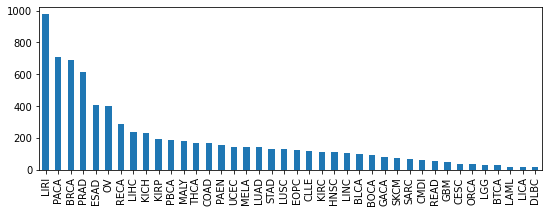

In [3]:
plt.figure(figsize=(9, 3))
ObsAll.tissue.value_counts().plot.bar();

In [4]:
ObsAll.is_nonsense.value_counts()

0    7330
1     281
Name: is_nonsense, dtype: int64

### Extended annotation

In [26]:
path_to_ann = "../data/external/CancerDataFromCampbell/HumanMtDnaRefSeq.fasta.ExtensiveMut.vcf.ann"
_cols = [1, 3, 4, 7]
_names = ['position','ref','var','annotation']
ExtAnnRaw = pd.read_csv(
    path_to_ann, sep="\t", header=None, comment="#", usecols=_cols, 
    names=_names,
)
ExtAnnRaw["ProtCodGene"] = ExtAnnRaw["annotation"].apply(lambda x: x.split("|")[3])
ExtAnnRaw["SubstType"] = ExtAnnRaw["annotation"].apply(lambda x: x.split("|")[1])

In [28]:
ExtAnnRaw.position.value_counts()

3106     6
11069    3
11039    3
11040    3
11041    3
        ..
5531     3
5532     3
5533     3
5534     3
16569    3
Name: position, Length: 16568, dtype: int64

In [ ]:

ExtAnn = ExtAnnRaw.copy()
After = ExtAnn.ref.iloc[3:].values
After = np.append(After, [None, None, None])
Before = ExtAnn.ref.iloc[:-3].values
_ = np.append(Before[::-1], [None, None, None])[::-1]
assert np.all(_[3:] == Before)
Before = _

ExtAnn["Before"] = Before
ExtAnn["After"] = After
ExtAnn["Context"] = ExtAnn["Before"] + ExtAnn["ref"] + ExtAnn["After"]
ExtAnn["Subst"] = ExtAnn["ref"] + ExtAnn["var"]
ExtAnn["Names"] = ExtAnn["Subst"] + ': ' + ExtAnn["Context"]
ExtAnn = ExtAnn.iloc[3:-3]
ExtAnn.head()

### Merge tables

In [13]:
# MERGE ObsAll & ExtAnn (all.x = TRUE)
print(ObsAll.shape)
ObsAllExt = pd.merge(ObsAll, ExtAnn, on=["position", "ref", "var"])
print(ObsAllExt.shape)
ObsAllExt = ObsAllExt.sort_values("position")
ObsAllExt = ObsAllExt[["tissue", "position", "Subst", "Names", "ProtCodGene", "SubstType"]]
print(ObsAllExt.shape)
ObsAllExt

(7611, 8)
(7611, 16)
(7611, 6)


,tissue,position,Subst,Names,ProtCodGene,SubstType
5086,MALY,35,GA,GA: GGG,ND1,upstream_gene_variant
4414,LIHC,39,CT,CT: GCT,ND1,upstream_gene_variant
618,BRCA,41,CT,CT: TCT,ND1,upstream_gene_variant
621,LIRI,41,CT,CT: TCT,ND1,upstream_gene_variant
620,LIRI,41,CT,CT: TCT,ND1,upstream_gene_variant
...,...,...,...,...,...,...
2753,KIRP,16566,GA,GA: CGA,ND6,upstream_gene_variant
2752,KIRP,16566,GA,GA: CGA,ND6,upstream_gene_variant
2751,KIRP,16566,GA,GA: CGA,ND6,upstream_gene_variant
2750,KICH,16566,GA,GA: CGA,ND6,upstream_gene_variant


In [14]:
ObsAllExt.SubstType.value_counts()

missense_variant                               3613
upstream_gene_variant                          2935
synonymous_variant                              805
stop_retained_variant                           121
stop_lost                                        55
stop_gained                                      52
start_lost                                       18
splice_region_variant&synonymous_variant         11
splice_region_variant&stop_retained_variant       1
Name: SubstType, dtype: int64

### "Expected" mutspec 

Reference genome doesn't contain state on 3107 position, it's N

In [164]:
def get_codon(pos):
    pic = (pos - 1) % 3
    start = pos - pic
    codon_df = Ref[Ref.position.isin(range(start, start + 3))]
    if len(codon_df) != 3:
        codon_str = None
    else:
        codon_str = "".join(codon_df.ref.values)
    return codon_str


def get_context(pos, l=1):
    context_df = Ref[Ref.position.isin(range(pos - l, pos + l + 1))]
    if len(context_df) != 3:
        context_str = None
    else:
        context_str = "".join(context_df.ref.values)    
    return context_str

def __prepare_codontable(codontable: Union[NCBICodonTableDNA, int]):
    if isinstance(codontable, NCBICodonTableDNA):
        pass
    elif isinstance(codontable, int):
        codontable = CodonTable.unambiguous_dna_by_id[codontable]
    else:
        ValueError("passed codontable is not appropriate")
    return codontable


def extract_syn_codons(codontable: Union[NCBICodonTableDNA, int]):
    """ extract synonymous (codons that mutate without amino acid change) 
    and fourfold codons from codon table

    return mapping[(cdn, pic)] of syn codons and set of ff codons
    """
    codontable = __prepare_codontable(codontable)
    aa2codons = defaultdict(set)
    for codon, aa in codontable.forward_table.items():
        aa2codons[aa].add(codon)

    syn_codons = defaultdict(int)
    for aa, codons in aa2codons.items():
        if len(codons) > 1:
            interim_dct = defaultdict(set)
            for i, slc in enumerate([slice(1, 3), slice(0, 3, 2), slice(0, 2)]):
                for codon in codons:
                    cdn_stump = codon[slc]
                    interim_dct[(cdn_stump, i)].add(codon)

            for key, aa_syn_codons in interim_dct.items():
                if len(aa_syn_codons) > 1:
                    pic = key[1]
                    for cdn in aa_syn_codons:
                        syn_codons[(cdn, pic)] += len(aa_syn_codons) - 1

    ff_codons = set()
    for (cdn, pic), num in syn_codons.items():
        if num == 3 and pic == 2:
            ff_codons.add(cdn)
    return dict(syn_codons), ff_codons


def is_syn_codons(codon1: str, codon2: str, codontable: Union[NCBICodonTableDNA, int]):
    """
    extract codons containing mutation that are synonymous

    return dict[codon: set[PosInCodon]]
    """
    codontable = __prepare_codontable(codontable)
    gc = codontable.forward_table
    return gc.get(codon1, "*") == gc.get(codon2, "*")


def get_alt(ser: pd.Series):
    ref_nuc, alt_nuc = list(ser.Subst)
    pic = ser.Pic - 1
    codon = list(ser.RefCodon)
    assert codon[pic] == ref_nuc, "reference nucleotide is not tha same as in codon"
    codon[pic] = alt_nuc
    alt_codon = "".join(codon)
    return alt_codon


syn_codons, ff_codons = extract_syn_codons(2)

In [207]:
path_to_gb = "../data/external/NC_012920.1.gb"
gb_file = next(SeqIO.parse(path_to_gb, "genbank"))
# for rec in gb_file:
#     print(repr(rec))


In [299]:
ftypes_nc = {'rRNA', 'tRNA'}
data = []

for ftr in gb_file.features:
    gene = ftr.extract(gb_file)
    seq = str(gene.seq)

    if ftr.type == "source":
        source = gene
    if ftr.type == "D-loop":
        ...  # TODO
        for pos, (nuc, pos_in_genome) in enumerate(zip(seq, list(ftr.location))):
            data.append({
                "Pos": pos_in_genome + 1,
                "PosInGene": pos + 1,
                "Nuc": nuc,
                "Type": ftr.type,
                "Strand": ftr.strand,

            })
        break
    elif ftr.type in ftypes_nc:
        gene_name = ftr.qualifiers["gene"][0]
        for pos, (nuc, pos_in_genome) in enumerate(zip(seq, list(ftr.location))):
            data.append({
                "Pos": pos_in_genome + 1,
                "PosInGene": pos + 1,
                "Nuc": nuc,
                "Type": ftr.type,
                "GeneName": gene_name,
                "Strand": ftr.strand,

            })
    elif ftr.type == 'CDS':
        gene_name = ftr.qualifiers["gene"][0]
        for pos, (nuc, pos_in_genome) in enumerate(zip(seq, list(ftr.location))):
            pic = pos % 3
            codon = seq[pos - pic: pos - pic + 3]
            context = seq[pos - 1: pos + 2]
            
            data.append({
                "Pos": pos_in_genome + 1,
                "PosInGene": pos + 1,
                "PosInCodon": pic + 1,
                "Nuc": nuc,
                # "Context": context,  # TODO get from source
                "Codon": codon,
                "Type": ftr.type,
                "GeneName": gene_name,
                "Strand": ftr.strand,

            })


In [300]:
pd.DataFrame(data).sort_values("Pos")

,Pos,PosInGene,Nuc,Type,Strand
575,1,576,C,D-loop,-1
574,2,575,T,D-loop,-1
573,3,574,A,D-loop,-1
572,4,573,G,D-loop,-1
571,5,572,T,D-loop,-1
...,...,...,...,...,...
580,16565,581,G,D-loop,-1
579,16566,580,C,D-loop,-1
578,16567,579,T,D-loop,-1
577,16568,578,A,D-loop,-1


In [301]:
gene = ftr.extract(gb_file)
gene

SeqRecord(seq=Seq('TGTGGGGGGTGTCTTTGGGGTTTGGTTGGTTCGGGGTATGGGGTTAGCAGCGGT...GAA'), id='<unknown id>', name='<unknown name>', description='<unknown description>', dbxrefs=[])

In [302]:
ftr

SeqFeature(CompoundLocation([FeatureLocation(ExactPosition(0), ExactPosition(576), strand=-1), FeatureLocation(ExactPosition(16023), ExactPosition(16569), strand=-1)], 'join'), type='D-loop', location_operator='join')

In [308]:
ftr.location

CompoundLocation([FeatureLocation(ExactPosition(0), ExactPosition(576), strand=-1), FeatureLocation(ExactPosition(16023), ExactPosition(16569), strand=-1)], 'join')

In [303]:
ftr.qualifiers

OrderedDict()

In [211]:
set([x.type for x in gb_file.features])

{'CDS', 'D-loop', 'gene', 'misc_feature', 'rRNA', 'source', 'tRNA'}

In [171]:
Ref = ExtAnnRaw.drop_duplicates("position").drop(
    ["annotation", "var", "SubstType"], axis=1).reset_index(drop=True)

Ref["Pic"] = (Ref.position - 1) % 3 + 1
Ref["Context"] = Ref.position.apply(get_context)
Ref["RefCodon"] = Ref.position.apply(get_codon)
Ref.dropna(inplace=True)
Ref

,position,ref,ProtCodGene,Pic,Context,RefCodon
1,2,A,ND1,2,GAT,GAT
2,3,T,ND1,3,ATC,GAT
3,4,C,ND1,1,TCA,CAC
4,5,A,ND1,2,CAC,CAC
5,6,C,ND1,3,ACA,CAC
...,...,...,...,...,...,...
16562,16564,A,ND6,1,CAC,ACG
16563,16565,C,ND6,2,ACG,ACG
16564,16566,G,ND6,3,CGA,ACG
16565,16567,A,ND6,1,GAT,ATG


In [172]:
# abcent 3107 +- context pos
Ref.head(3110).tail(10)

,position,ref,ProtCodGene,Pic,Context,RefCodon
3101,3102,T,ND1,3,ATC,TAT
3102,3103,C,ND1,1,TCT,CTA
3103,3104,T,ND1,2,CTA,CTA
3104,3105,A,ND1,3,TAC,CTA
3107,3109,T,ND1,1,TTC,TCA
3108,3110,C,ND1,2,TCA,TCA
3109,3111,A,ND1,3,CAA,TCA
3110,3112,A,ND1,1,AAA,AAT
3111,3113,A,ND1,2,AAT,AAT
3112,3114,T,ND1,3,ATT,AAT


### Merge tables again, but with ref annotation

In [173]:
ObsAllExtAnn = pd.merge(ObsAllExt, Ref.drop(["ref", "ProtCodGene"], axis=1), on="position")
ObsAllExtAnn["AltCodon"] = ObsAllExtAnn.apply(get_alt, axis=1)
ObsAllExtAnn["IsSyn"] = ObsAllExtAnn.apply(lambda s: is_syn_codons(s.RefCodon, s.AltCodon, 2), axis=1)
ObsAllExtAnn["IsFoufold"] = ObsAllExtAnn.RefCodon.isin(ff_codons) & (ObsAllExtAnn.Pic == 3)

ObsAllExtAnn.head()

,tissue,position,Subst,Names,ProtCodGene,SubstType,Pic,Context,RefCodon,AltCodon,IsSyn,IsFoufold
0,MALY,35,GA,GA: GGG,ND1,upstream_gene_variant,2,GGG,GGG,GAG,False,False
1,LIHC,39,CT,CT: GCT,ND1,upstream_gene_variant,3,GCT,AGC,AGT,True,False
2,BRCA,41,CT,CT: TCT,ND1,upstream_gene_variant,2,TCT,TCT,TTT,False,False
3,LIRI,41,CT,CT: TCT,ND1,upstream_gene_variant,2,TCT,TCT,TTT,False,False
4,LIRI,41,CT,CT: TCT,ND1,upstream_gene_variant,2,TCT,TCT,TTT,False,False


In [178]:
assert np.all(ObsAllExtAnn.IsSyn | ObsAllExtAnn.IsFoufold == ObsAllExtAnn.IsSyn)

In [132]:
ObsAllExtAnn.IsFoufold.value_counts()

False    6400
True     1211
Name: IsFoufold, dtype: int64

In [174]:
ObsAllExtAnn.IsSyn.value_counts()

False    4965
True     2646
Name: IsSyn, dtype: int64

In [179]:
ObsAllExtAnn.SubstType.value_counts()

missense_variant                               3613
upstream_gene_variant                          2935
synonymous_variant                              805
stop_retained_variant                           121
stop_lost                                        55
stop_gained                                      52
start_lost                                       18
splice_region_variant&synonymous_variant         11
splice_region_variant&stop_retained_variant       1
Name: SubstType, dtype: int64

In [135]:
ObsAllExtAnn[(ObsAllExtAnn.SubstType == "stop_lost") & ObsAllExtAnn.IsFoufold]

,tissue,position,Subst,Names,ProtCodGene,SubstType,Pic,Codon,IsFoufold,Context
2543,PACA,4557,TC,TC: CTG,ND2,stop_lost,3,CCT,True,CTG
2638,UCEC,4809,TC,TC: CTG,ND2,stop_lost,3,TCT,True,CTG
2776,RECA,5169,TC,TC: CTG,ND2,stop_lost,3,CCT,True,CTG
4682,LIRI,10395,TC,TC: CTG,ND3,stop_lost,3,ACT,True,CTG


In [104]:
##### DEFINE MAIN SUBSETS OF MUTATIONS:
SubsetGenes = ['withoutNd6'] #  ['withNd6','withoutNd6','Nd6Only']
SubsetSubstitutions = ['synonymous','AllExceptStopGains'] #  ['synonymous','non-synonymous','SynAndNons']